In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from PIL import Image
import np_utils

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['labels.csv', 'train', 'test', 'sample_submission.csv']


In [2]:
import time
import cv2
import os
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import struct
from os import listdir

from keras.layers import Flatten, Dense, Conv2D, Dropout, LeakyReLU, MaxPooling2D
from keras.models import Sequential, Model
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.applications.resnet50 import ResNet50
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import GridSearchCV, ParameterGrid
from keras import regularizers

img_height = 224
img_width = 224

callbacks = [EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint('best_model_cb.h5', verbose=1, save_best_only=True, save_weights_only=True)]

callbacks_nosave = [EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1)]

Using TensorFlow backend.


In [3]:
#Load csv file containing image filenames and labels into dataframe
df = pd.read_csv('../input/labels.csv')


In [4]:
#An array containing a representative subset of the training set to determine the normalisation statistics.
#Ideally we'd use the entire training set but memory limitations prevent it.  
image_array = []

path = '../input/train/'

for image in listdir(path)[0:5000]:
    try:
        img = load_img(path+'/'+image, target_size=(224,224))  
        x = img_to_array(img)
        image_array.append(x)
    except:
        continue
image_array = np.array(image_array)
print(np.shape(image_array))

(5000, 224, 224, 3)


In [5]:
#Define the image augmentation parameters and fit the datagen to the array created earlier.

datagen = ImageDataGenerator(
                                #rescale = 1/255.,                        
                                samplewise_std_normalization=False,                            
                                samplewise_center=True,
                                featurewise_center=True,
                                featurewise_std_normalization=False,
                                rotation_range=20,
                                height_shift_range=0.2,
                                width_shift_range=0.2,
                                zoom_range=0.1,
                                horizontal_flip=True,
                                validation_split=0.2)

datagen.fit(image_array)

print('done')



done


In [6]:
#Create the image generators
train_generator = datagen.flow_from_dataframe(dataframe=df, directory='../input/train', x_col='id', y_col='breed', target_size=(img_height, img_width), 
                    color_mode='rgb', class_mode='categorical', subset='training', batch_size=64, shuffle=True, has_ext=False)

val_generator = datagen.flow_from_dataframe(dataframe=df, directory='../input/train', x_col='id', y_col='breed', target_size=(img_height, img_width), 
                    color_mode='rgb', class_mode='categorical', subset='validation', batch_size=64, shuffle=True, has_ext=False)


Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.


In [7]:
#Create the neural network model - Note this is built on the ResNet50 pretrained model - Only the new outer
#layers are trained. 

def build_model():

    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)
    
    basemodel = ResNet50(input_tensor=None, input_shape=input_shape, weights='imagenet', include_top=False)

    for layer in basemodel.layers[:-3]:
        layer.trainable = False
    
    topmodel = basemodel.output

    topmodel = Flatten()(topmodel)

    #topmodel = BatchNormalization()(topmodel)
    
    topmodel = Dense(1500, activation='relu')(topmodel)
    topmodel = BatchNormalization()(topmodel)
    topmodel = Dropout(0.01)(topmodel)
    
    #topmodel = Dense(700, activation='relu')(topmodel)
    #topmodel = BatchNormalization()(topmodel)
    #topmodel = Dropout(0.01)(topmodel)
    
    predictions = Dense(120, activation = "softmax")(topmodel)

    model = Model(inputs= basemodel.input, outputs= predictions)

    adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

    model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
    
    return model

model = build_model()


/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


Epoch 1/50
20/20 [==============================] - 40s 2s/step - loss: 5.5287 - acc: 0.0930 - val_loss: 5.9771 - val_acc: 0.1625
Epoch 2/50
20/20 [==============================] - 28s 1s/step - loss: 3.6123 - acc: 0.2163 - val_loss: 4.5631 - val_acc: 0.2188
Epoch 3/50
20/20 [==============================] - 28s 1s/step - loss: 2.9536 - acc: 0.3086 - val_loss: 3.8034 - val_acc: 0.2906
Epoch 4/50
20/20 [==============================] - 27s 1s/step - loss: 2.6529 - acc: 0.3367 - val_loss: 3.6600 - val_acc: 0.2844
Epoch 5/50
20/20 [==============================] - 28s 1s/step - loss: 2.5339 - acc: 0.3625 - val_loss: 3.3377 - val_acc: 0.3187
Epoch 6/50
20/20 [==============================] - 26s 1s/step - loss: 2.4475 - acc: 0.3820 - val_loss: 2.9998 - val_acc: 0.3875
Epoch 7/50
20/20 [==============================] - 30s 1s/step - loss: 1.9421 - acc: 0.4797 - val_loss: 2.7643 - val_acc: 0.3797
Epoch 8/50
20/20 [==============================] - 29s 1s/step - loss: 1.5556 - acc: 0.58

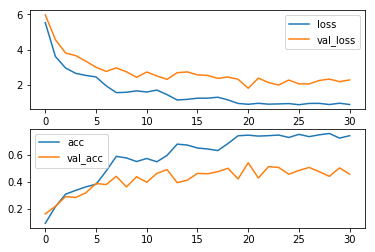

In [8]:
history = model.fit_generator(train_generator, steps_per_epoch=20, 
                validation_data=val_generator, validation_steps=5,epochs=50, callbacks = callbacks_nosave)

plt.subplot('211')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')

plt.subplot('212')
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend(loc='best')

plt.show()

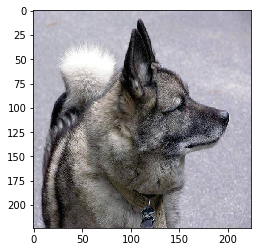

In [ ]:
for filename in listdir('../input/test')[0:5]:
    img = load_img('../input/test/'+filename, target_size=(224,224))
    plt.imshow(img)
    plt.show()
    
    #get Preds
    img = datagen.standardize(img)
    img = np.reshape(img,(1,224,224,3))
    class_names = list(val_generator.class_indices.keys())
    #print(class_names)
    preds = model.predict(img)
    pred_order = np.argsort(preds, axis=-1)
    #print(pred_order)
    print('Prediction 1:', class_names[pred_order[0][-1]])
    print('Prediction 2:', class_names[pred_order[0][-2]])
    print('Prediction 3:',class_names[pred_order[0][-3]])
    


In [ ]:
test_generator = datagen.flow_from_directory(
        directory='../testdummy/',
        target_size=(224, 224),
        color_mode='rgb',
        save_to_dir='../genims/',
        batch_size=1,
        class_mode=None,  # only data, no labels
        shuffle=False)  # keep data in same order as labels

test_generator.reset()
pred_array = model.predict_generator(test_generator)
print('fin')

In [ ]:
from os import listdir

examples_submission = pd.read_csv('../input/sample_submission.csv')

class_labels = val_generator.class_indices
test_preds = pd.DataFrame(columns=['id',list(class_labels.keys())])

path = '../input/test'

ids_list = []

for filename in listdir(path):
    
    ids_list.append(filename.split('.')[0])
    
#Put predictions into the appropriate format for submission

ids_list = pd.DataFrame(ids_list)
ids_list.columns = ['id']

preds_df = pd.DataFrame(pred_array)
preds_df.columns = examples_submission.columns[1:]

preds_df.insert(0, 'id', ids_list)

preds_df.to_csv('submission.csv',index=False)

print('FINISHED')


In [ ]:
preds_df.head()